# Research on apartment sales ads

We work the data from a real estate agency. It is an archive of sales ads for realty in St. Petersburg, Russia, and the surrounding areas collected over the past few years. The goal is to learn how to determine the market value of real estate properties. The task is to define the parameters. This will make it possible to build an automated system that is capable of detecting anomalies and fraudulent activity.

There are two different types of data available for every apartment for sale. The first type is a user’s input. The second type is received automatically based upon the map data. For example, the distance from the city center, airport, the nearest park or body of water. 

## Description of the data

The dataset contains the following fields:

price

model_year

model

condition

cylinders

fuel — gas, diesel, etc.

odometer — the vehicle's mileage when the ad was published

transmission

paint_color

is_4wd — whether the vehicle has 4-wheel drive (Boolean type)

date_posted — the date the ad was published

days_listed — from publication to removal

### Step 1. Open the data file and study the general information. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np  

data = pd.read_csv('/datasets/real_estate_data_us.csv', sep='\t')




data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
date_posted          23699 non-null object
days_listed          20518 non-null float64
last_price           23699 non-null float64
bedrooms             23699 non-null int64
kitchen_area         21421 non-null float64
living_area          21796 non-null float64
total_area           23699 non-null float64
balconies            12180 non-null float64
ceiling_height       14504 non-null float64
floors_total         23613 non-null float64
floor                23699 non-null int64
total_images         23699 non-null int64
bike_parking         2775 non-null object
is_studio            23699 non-null bool
is_open_plan         23699 non-null bool
locality_name        23650 non-null object
airport_dist         18157 non-null float64
city_center_dist     18180 non-null float64
park_dist            8079 non-null float64
parks_within_3000    18181 non-null float64
pond_dist            9110 no

We see that in some cases we don't have mych data at all. I make an assumption that in columns like bike_parking,  parks_within_3000, ponds  etc we have no information, people don't know if there are any ponds or parking lots, so we can't fill in NA. Mean won't work,because there may be none of them, or they can be everywhere, we don't know that.


### Conclusion

### Step 2. Data preprocessing

In [2]:
#I am filling the missing data in the columns that I will need to work with later, not all of them will be needed.
data['kitchen_area'] = data['kitchen_area'].fillna(value=data['kitchen_area'].median())
data['living_area'] = data['living_area'].fillna(value=data['living_area'].median())

data['date_posted'] = pd.to_datetime(data['date_posted'])# I changed date_posted to datetime format  
data['locality_name'] = data['locality_name'].astype(str)#I changed the type from object to string,I think it's more appropriate.
data.locality_name.apply(type).unique()
data['locality_name'] = data['locality_name'].fillna(value='undefined')

data['balconies'] = data['balconies'].fillna(value=0) #I assume that if there's nan it means no balcony
data['floors_total'] = data['floors_total'].fillna(value=data['floors_total'].median())#filling NA in floors
data['days_listed'] = data['days_listed'].fillna(value=data['days_listed'].median())
new_ceiling = data['ceiling_height']/10
data.loc[data['ceiling_height'] >= 20, 'ceiling_height'] = new_ceiling #removing outliers in this column, deleting abnormally high ceilings like  20-40 m and filling NA
data['ceiling_height'] = data['ceiling_height'].fillna(value=data['ceiling_height'].median())

data['city_center_dist'].fillna(data.groupby('locality_name')['city_center_dist'].transform('median'),inplace=True)#filling NA in city_center


#print(data['locality_name'].unique())
print(data['kitchen_area'])
print(data['last_price'].head(10))




0        25.00
1        11.00
2         8.30
3         9.10
4        41.00
         ...  
23694    13.83
23695     8.50
23696     9.10
23697    23.30
23698     9.00
Name: kitchen_area, Length: 23699, dtype: float64
0     260000.0
1      67000.0
2     103920.0
3    1298000.0
4     200000.0
5      57800.0
6      74000.0
7     158300.0
8      58000.0
9     108000.0
Name: last_price, dtype: float64


I chose to replace numeric missing values with median since it is is less sensitive to outliers and better reflects the data than, say, the mean. The non-numeric variables I replaced with 'undefined', because we can not deduce the replacement. We can also observe, that the columns with the most missing values are the ones with information concerning the environment around the appartments, not the appartments themselves, like: pond district, bike parking, park district etc. When it comes to the appartments, most missing values are in the column "balconies", where I suppose those without balconies just didn't mark eanything, and ceiling height which, I suppose, not everyone measures, and hardly everyone requires of their nlandlords, unlike things like price, number of rooms etc. which are absolutely necessary.


### Step 3. Make calculations and add them to the table

In [3]:


#floor
def get_floor (floor, total_floor):
    if floor == 1:
        return 'first'
    elif floor == total_floor:
        return 'last'
    else:
        return 'other'
    
data['floor_level'] = data.apply(lambda x: get_floor(x['floor'], x['floors_total']), axis=1)
data['price_per_sqm'] = data['last_price'] / data['total_area']

data['date_posted_year'] = data['date_posted'].dt.year

data['date_posted_month'] = data['date_posted'].dt.month

data['date_posted_day'] = data['date_posted'].dt.day


data['kitchen_ratio'] = data['kitchen_area'] / data['total_area']   
data['living_ratio'] = data['living_area'] / data['total_area']



print(data)
print(data['last_price'].head(10))
#print(data['locality_name'].isnull().any())
print(data['balconies'].head(10))

      date_posted  days_listed  last_price  bedrooms  kitchen_area  \
0      2019-03-07         95.0    260000.0         3         25.00   
1      2018-12-04         81.0     67000.0         1         11.00   
2      2015-08-20        558.0    103920.0         2          8.30   
3      2015-07-24        424.0   1298000.0         3          9.10   
4      2018-06-19        121.0    200000.0         2         41.00   
...           ...          ...         ...       ...           ...   
23694  2017-03-21         95.0    194000.0         3         13.83   
23695  2018-01-15         45.0     62000.0         3          8.50   
23696  2018-02-11         95.0     50000.0         2          9.10   
23697  2017-03-28        602.0    229500.0         2         23.30   
23698  2017-07-21         95.0     27000.0         1          9.00   

       living_area  total_area  balconies  ceiling_height  floors_total  ...  \
0             51.0      108.00        0.0            2.70          16.0  ...   

### Step 4. Conduct exploratory data analysis and follow the instructions below:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f19b01a1bd0>]],
      dtype=object)

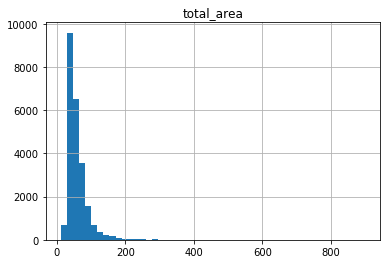

In [4]:
data.hist('total_area', bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f19b00c0310>]],
      dtype=object)

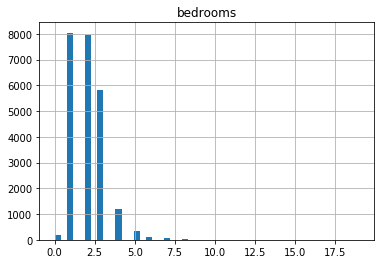

In [5]:
data.hist('bedrooms', bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f19b00061d0>]],
      dtype=object)

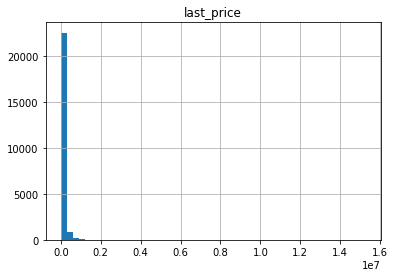

In [6]:
data.hist('last_price', bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f19af7d6cd0>]],
      dtype=object)

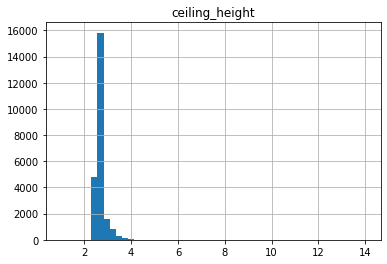

In [7]:
data.hist('ceiling_height', bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f19af788f10>]],
      dtype=object)

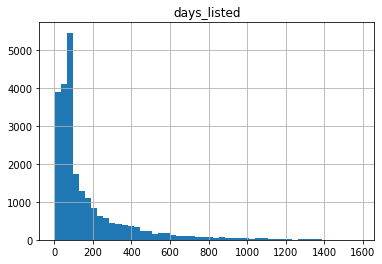

In [8]:
data.hist('days_listed', bins=50)

169.36022616988058
95.0


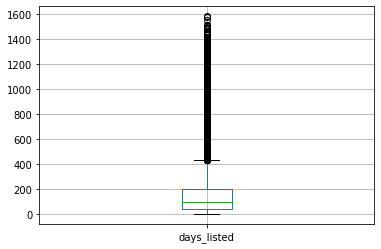

In [9]:
#Examine the time it's taken to sell the apartment and plot a histogram.
print(data['days_listed'].mean())
print(data['days_listed'].median())

data.boxplot(column='days_listed')
plt.show()

In [10]:
#removing outliers from the df by column for relevant columns, IQR based filter. returns filtered dataframe

def subset_by_iqr(df, column, whisker_width=1.5):
    q1 = df[column].quantile(0.25)                 
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    
    filter = (df[column] >= q1 - whisker_width*iqr) & (df[column] <= q3 + whisker_width*iqr)
    return df.loc[filter]                                                     


data = subset_by_iqr(data, 'days_listed', whisker_width=1.5)
data = subset_by_iqr(data, 'total_area', whisker_width=1.5)
data = subset_by_iqr(data, 'bedrooms', whisker_width=1.5)
data = subset_by_iqr(data, 'last_price', whisker_width=1.5)
data = subset_by_iqr(data, 'ceiling_height', whisker_width=1.5)


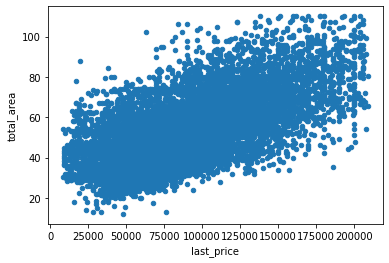

In [11]:
#Which factors have had the biggest influence on an apartment’s price? 
data.plot(x='last_price', y='total_area', kind='scatter')
plt.show()

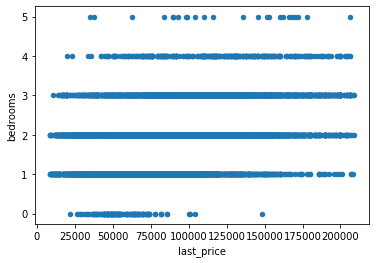

In [12]:
data.plot(x='last_price', y='bedrooms', kind='scatter')
plt.show()

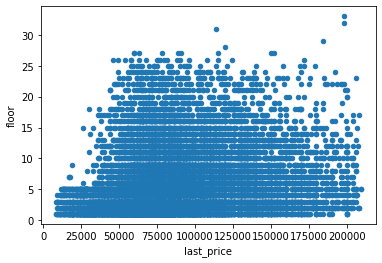

In [13]:
data.plot(x='last_price', y='floor', kind='scatter')
plt.show()



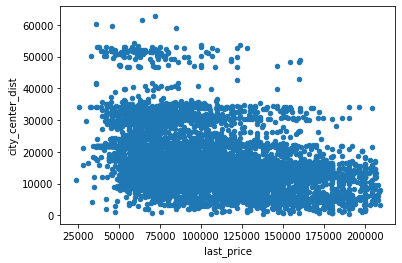

In [14]:
data.plot(x='last_price', y='city_center_dist', kind='scatter')
plt.show()

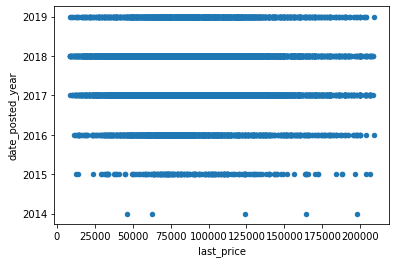

In [15]:
data.plot(x='last_price', y='date_posted_year', kind='scatter')
plt.show()

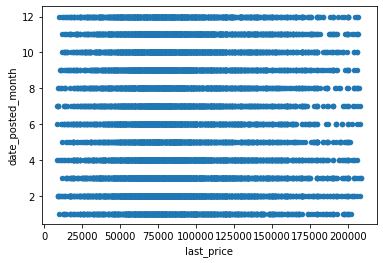

In [16]:
data.plot(x='last_price', y='date_posted_month', kind='scatter')
plt.show()

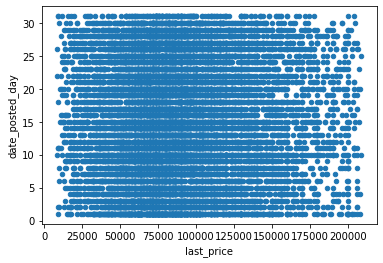

In [17]:
data.plot(x='last_price', y='date_posted_day', kind='scatter')
plt.show()

In [18]:

#Select the 10 localities
print(data['locality_name'].value_counts().sort_values(ascending=False).head(10)) 


data_one = data.query('locality_name=="Saint Petersburg"')
print(data_one['price_per_sqm'].mean())

data_two = data.query('locality_name=="Murino village"')
print(data_two['price_per_sqm'].mean())

data_three = data.query('locality_name=="Shushary village"')
print(data_three['price_per_sqm'].mean())

data_four = data.query('locality_name=="Vsevolozhsk"')
print(data_four['price_per_sqm'].mean())

data_five = data.query('locality_name=="Pushkin"')
print(data_five['price_per_sqm'].mean())

data_six = data.query('locality_name=="Kolpino"')
print(data_six['price_per_sqm'].mean())

data_seven = data.query('locality_name=="Pargolovo village"')
print(data_seven['price_per_sqm'].mean())

data_eight = data.query('locality_name=="Gatchina"')
print(data_eight['price_per_sqm'].mean())

data_nine = data.query('locality_name=="Kudrovo village"')
print(data_nine['price_per_sqm'].mean())

data_ten = data.query('locality_name=="Vyborg"')
print(data_ten['price_per_sqm'].mean())

#after printing the mean we can see that maximum and minimum prices are,respectively, Saint Petersburg and Vyborg



Saint Petersburg     7523
Murino village        423
Shushary village      338
Pargolovo village     274
Vsevolozhsk           258
Kudrovo village       197
Kolpino               190
Pushkin               184
Gatchina              182
Vyborg                148
Name: locality_name, dtype: int64
2066.887655533734
1709.763975048158
1568.9158628524358
1337.8138788278777
2003.6816058870827
1503.7885065687938
1798.5308186877503
1362.4576286336874
1857.9989498387104
1153.5787868266557


   index date_posted  days_listed  last_price  bedrooms  kitchen_area  \
0      7  2019-04-18         95.0    158300.0         2          18.9   
1     10  2017-11-16        137.0    101000.0         1           8.5   
2     15  2017-11-18         19.0     93000.0         1           7.6   
3     21  2018-03-14        310.0     64000.0         1           5.7   
4     24  2015-10-31        265.0    130000.0         2          19.6   

   living_area  total_area  balconies  ceiling_height  ...  parks_within_3000  \
0         30.0        71.6        2.0            2.65  ...                0.0   
1         20.3        39.6        0.0            2.67  ...                1.0   
2         20.5        39.0        1.0            2.65  ...                1.0   
3         16.9        31.6        1.0            2.65  ...                1.0   
4         46.5        97.2        0.0            2.65  ...                3.0   

   pond_dist  ponds_within_3000 floor_level  price_per_sqm  date_posted_ye

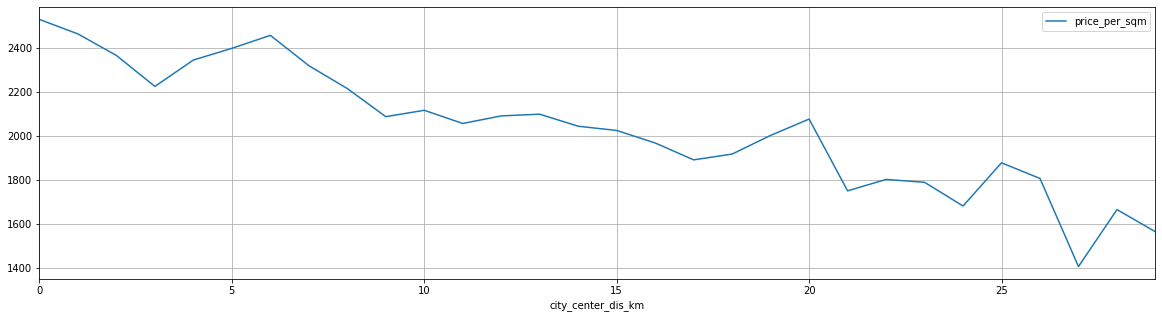

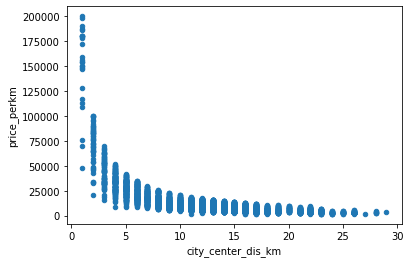

In [19]:
#"Thoroughly look at apartment offers ...
dataSpb = data.query('locality_name == "Saint Petersburg"').reset_index()
print(dataSpb.head())
dataSpb['city_center_dis_km']= (dataSpb['city_center_dist']/1000).round()
dataSpb['price_perkm'] = (dataSpb['last_price'] / dataSpb['city_center_dis_km']).round(decimals=2)

distance_price=dataSpb.pivot_table(index='city_center_dis_km', values='price_per_sqm', aggfunc='mean')
distance_price.plot(grid=True, figsize=(20, 5))
dataSpb.plot(x='city_center_dis_km', y='price_perkm', kind='scatter')


plt.show()
#we can see on the scatter plot that prices drop at 20 km

   index date_posted  days_listed  last_price  bedrooms  kitchen_area  \
0      7  2019-04-18         95.0    158300.0         2          18.9   
1     10  2017-11-16        137.0    101000.0         1           8.5   
2     15  2017-11-18         19.0     93000.0         1           7.6   
3     21  2018-03-14        310.0     64000.0         1           5.7   
4     24  2015-10-31        265.0    130000.0         2          19.6   

   living_area  total_area  balconies  ceiling_height  ...  parks_within_3000  \
0         30.0        71.6        2.0            2.65  ...                0.0   
1         20.3        39.6        0.0            2.67  ...                1.0   
2         20.5        39.0        1.0            2.65  ...                1.0   
3         16.9        31.6        1.0            2.65  ...                1.0   
4         46.5        97.2        0.0            2.65  ...                3.0   

   pond_dist  ponds_within_3000 floor_level  price_per_sqm  date_posted_ye

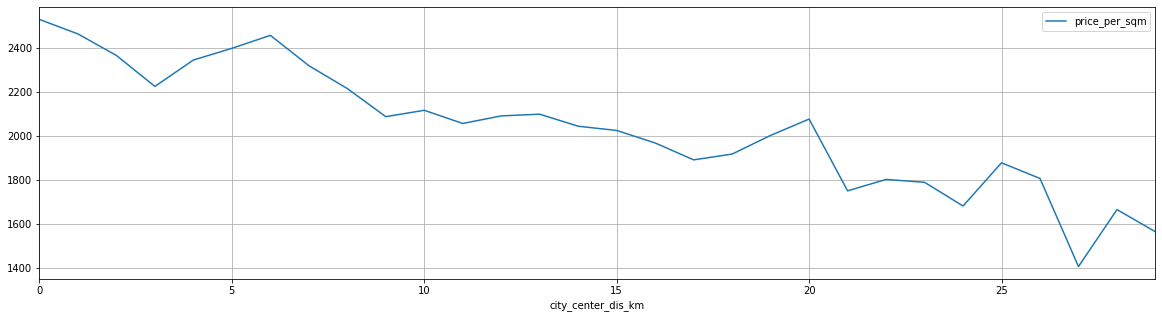

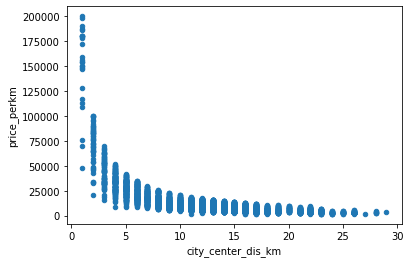

In [20]:
#"Thoroughly look at apartment offers ...
dataSpb = data.query('locality_name == "Saint Petersburg"').reset_index()
print(dataSpb.head())
dataSpb['city_center_dis_km']= (dataSpb['city_center_dist']/1000).round()
dataSpb['price_perkm'] = (dataSpb['last_price'] / dataSpb['city_center_dis_km']).round(decimals=2)

distance_price=dataSpb.pivot_table(index='city_center_dis_km', values='price_per_sqm', aggfunc='mean')
distance_price.plot(grid=True, figsize=(20, 5))
dataSpb.plot(x='city_center_dis_km', y='price_perkm', kind='scatter')


plt.show()
#we can see on the scatter plot that prices drop at 20 km

In [21]:
#making a df relevant for the last task
newdata1 = dataSpb.query('city_center_dis_km >= 25').reset_index() 
newdata2 = newdata1.filter(['total_area','last_price','ceiling_height', 'bedrooms'], axis=1)
print(newdata1.head())
print(newdata2.head())
print(newdata2.corr())

   level_0  index date_posted  days_listed  last_price  bedrooms  \
0       72    253  2018-03-28         75.0     66800.0         1   
1      136    465  2017-05-22        349.0     98000.0         2   
2      151    539  2018-06-25         45.0     65000.0         1   
3      328   1111  2015-10-14        285.0     81440.0         1   
4      364   1239  2017-12-21        147.0     67100.0         1   

   kitchen_area  living_area  total_area  balconies  ...  ponds_within_3000  \
0         10.00        19.00       37.00        0.0  ...                1.0   
1         11.33        34.00       69.30        1.0  ...                0.0   
2          9.10        30.00       40.00        0.0  ...                1.0   
3         12.00        16.00       38.00        1.0  ...                0.0   
4          9.95        14.56       37.77        1.0  ...                1.0   

   floor_level  price_per_sqm  date_posted_year date_posted_month  \
0        other    1805.405405              2018

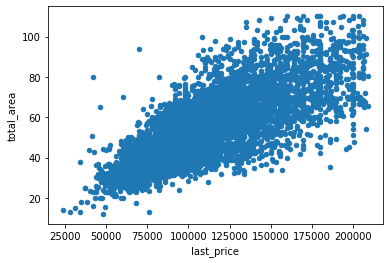

In [22]:
dataSpb.plot(x='last_price', y='total_area', kind='scatter')
plt.show()

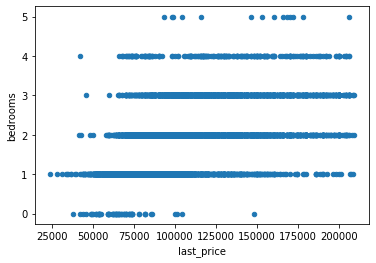

In [23]:
dataSpb.plot(x='last_price', y='bedrooms', kind='scatter')
plt.show()

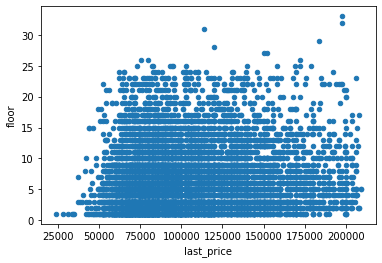

In [24]:
dataSpb.plot(x='last_price', y='floor', kind='scatter')
plt.show()

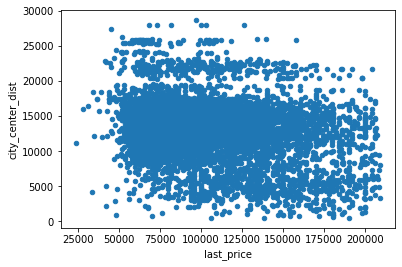

In [25]:
dataSpb.plot(x='last_price', y='city_center_dist', kind='scatter')
plt.show()

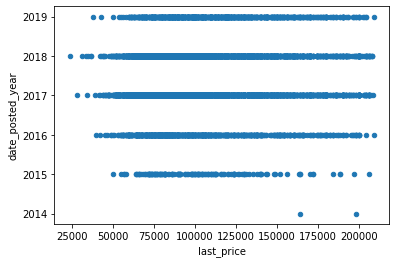

In [26]:
dataSpb.plot(x='last_price', y='date_posted_year', kind='scatter')
plt.show()

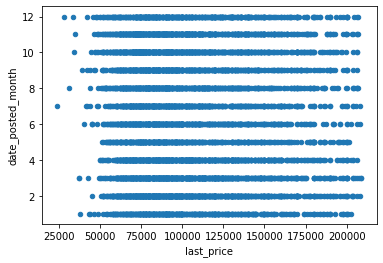

In [27]:
dataSpb.plot(x='last_price', y='date_posted_month', kind='scatter')
plt.show()

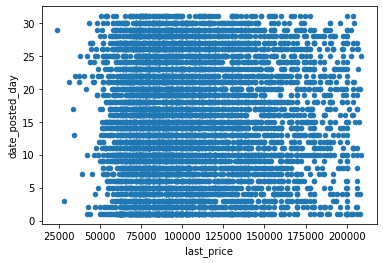

In [28]:
dataSpb.plot(x='last_price', y='date_posted_day', kind='scatter')
plt.show()



#it seems that in SPB there is a very high positive correlation between the price and bedrooms and total area and a very small negative correlatopn between price and ceiling height, which is surprising. 

Overall, when it comes to the general conclusion, we can state the following.

General conclusion for all the data:
Judging from the scatterplot there seems to be a moderate positive correlation between total area and the price;
There doesn't seem to be a relevant correlation with the number of bedrooms
The flats on floors 5+ are on average more expensive,and the appartments closer than apprpximately 20 km to city center tend to be more expensive.
After 20 km the prices skew to the left.
Date the ad was posted doesn't seem to matter much.

For Spb specifically:
The total area to price positive correlation remains and is even more pronounced, as can be seen from the code below.
The prices for appartments depending on the number of bedrooms differ much more dramatically: the prices for 2 and 3 bedrooms are instantly much higher than for one, the 0 bedroom ones, which are, I suppose, the studios, are still moderately more expensive than 1 bedroom ones.
With the floors it gets interesting: for all locations prices tend to drastically increase after te 5 floor. But for Spb, they go up significantly right after the first floor. It is hard to imagine why.

Overall, we can say that the same trends hold true in Spb as in all location with the exeption of bedrooms and floors in correlation with price. Overall prices are obviously higher in Spb than anywhere else.

We can say that the factor that is the most important when it comes to desiding the price of the flat is the total area, there is a very high positive correlation with the price. Other variables are obviously also relevant, however, this seems to be the one that influences price the most.


In [29]:
print(data['total_area'].corr(data['last_price']))
print(dataSpb['total_area'].corr(dataSpb['last_price']))


0.6618905811429784
0.7883139566323257
